Running WaveStats Algorithm:
Extracting data from file...


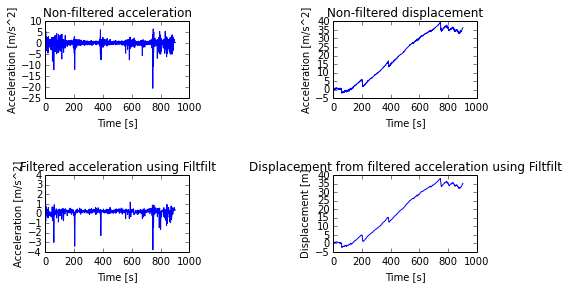

In [1]:
#Purisa Jasmine Simmons
#July 12, 2018
#Algorithm to filter acceleration data using FiltFilt, before calculating displacements.

%matplotlib inline

from scipy import signal

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from plotly import tools
import plotly.offline
import plotly.graph_objs as go

import math
import re

#Need to do peak-picking before algorithm runs:
#1. Read through file, save all times and accelerations:
print('Running WaveStats Algorithm:')

#Reading data from filename_r
filename_r = "Motion_14637.CSV"
read_file = open(filename_r, "r")

#Initialize lists
t1 = 0 
t2 = 0
time_e_list = []  #list of ***elapsed*** times
time_o_list = []  #list of ***offset*** times
acc_list = []     #list of estimated accelerations
disp_list = []    #list of estimated displacements
disp_list_f = []    #list of estimated displacements


print 'Extracting data from file...'
with open(filename_r, 'r') as f: 
  for line in f:
    str_array = line.split(',')  #separates each line into an array on commas

    #-------Calculating Time Offset--------#
    if str_array[0] == "UTC":
      t1 = 0
      t2 = 0
      time_e_list.append(0)
      time_o_list.append(0)

    else:
      t2 = str_array[0]

      if (t2 != 0 and t1 != 0 and str_array[2] != "N/A"):
        time_regex = r"(\.\d+)"
        t2_val = float(re.search(time_regex, t2).group(1))
        t1_val = float(re.search(time_regex, t1).group(1))

        #print t2_val
        #print t1_val

        t_out = t2_val - t1_val #measured in secs

        #t_out is the time offset between two subsequent samples
        if (t_out < 0): 
          t_out = t_out + 1

        #print ("Printing time_offsets")
     
        last = len(time_e_list) - 1
        last_time = time_e_list[last] 
        new_time = t_out + last_time  #new_time is the total elapsed time

        time_e_list.append(new_time)
        time_o_list.append(t_out)

      if (str_array[2] != "N/A" and str_array[3] != "N/A" and \
        str_array[4] != "N/A" and str_array[2] != "IMU A1"):

        g_const = 512     #g_const is scaling constant: 500 (500raw units = 1g)
        gravity = -9.80665 #gravity is the constant 9.80665m^2/s 

        ax = int(str_array[2])  #x-axis (horizontal direction 1)
        #ax = (ax/g_const)*gravity
        ay = int(str_array[3])  #y-axis, affected by gravity (vertical)
        #ay = (ay/g_const)*gravity
        az = int(str_array[4])  #z-axis (horizontal direction 2)
        #az = (az/g_const)*gravity


        #Calculate the magnitude of acceleration from all three axes:
        a_mag = math.sqrt(ax**2 + ay**2 + az**2)

        #Double integrate aA to get approximate distance b/w wave trough and crest
        #aA = a_mag - gravity     #aA is the approximated vertical acceleration
        aA = (a_mag/g_const)*gravity - gravity

    
        #print aA

        acc_list.append(aA)


    #Reset t1 and t2 after t_out is calculated
    t1 = t2
    t2 = 0

#----------Here, after both lists created, now filter acceleration data----------
time_array = np.array(time_e_list)
acc_array = np.array(acc_list)


#-------Generating non-filtered displacement data here:
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_list)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_list[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list) - 1      #index of last element in disp_list
    last_d = disp_list[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#-------Now filtering acceleration data:

#b is the numerator coefficient vector of the filter
#a is the denominator coefficient vector of the filter
b, a = signal.butter(8, 0.125)
x = acc_array
y = signal.filtfilt(b, a, x, padlen=150)

acc_fil = y
#-------------------Here, after filtering---------------
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_fil)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list_f.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_fil[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list_f) - 1      #index of last element in disp_list
    last_d = disp_list_f[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list_f.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list_f)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#--------Here, after calculations, ready to graph---------

disp_array = np.array(disp_list)
disp_array_f = np.array(disp_list_f)
acc_fil_array = np.array(acc_fil)

plt.subplot(2, 2, 1)
plt.plot(time_array, acc_array)
plt.title('Non-filtered acceleration')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 2)
plt.plot(time_array, disp_array)
plt.title('Non-filtered displacement')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 3)
plt.plot(time_array, acc_fil_array)
plt.title('Filtered acceleration using Filtfilt')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')
         
plt.subplot(2, 2, 4)
plt.plot(time_array, disp_array_f)
plt.title('Displacement from filtered acceleration using Filtfilt')
plt.ylabel('Displacement [m]')
plt.xlabel('Time [s]')


#plt.tight_layout()

plt.subplots_adjust(left=0.001, bottom=0.1, right=1.0, top=0.9,
                wspace=1.0, hspace=1.0)

plt.show()





In [23]:
#Using another data set from a different ride:



Running WaveStats Algorithm:
Extracting data from file...


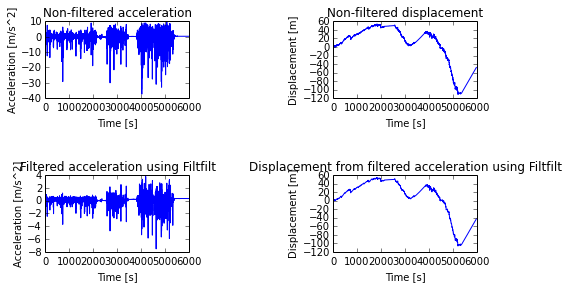

In [26]:
#Purisa Jasmine Simmons
#July 12, 2018
#Algorithm to filter acceleration data using FiltFilt, before calculating displacements.

%matplotlib inline

from scipy import signal

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from plotly import tools
import plotly.offline
import plotly.graph_objs as go

import math
import re

#Need to do peak-picking before algorithm runs:
#1. Read through file, save all times and accelerations:
print('Running WaveStats Algorithm:')

#Reading data from filename_r
filename_r = "Motion_14644.CSV"
read_file = open(filename_r, "r")

#Initialize lists
t1 = 0 
t2 = 0
time_e_list = []  #list of ***elapsed*** times
time_o_list = []  #list of ***offset*** times
acc_list = []     #list of estimated accelerations
disp_list = []    #list of estimated displacements
disp_list_f = []    #list of estimated displacements


print 'Extracting data from file...'
with open(filename_r, 'r') as f: 
  for line in f:
    str_array = line.split(',')  #separates each line into an array on commas

    #-------Calculating Time Offset--------#
    if str_array[0] == "UTC":
      t1 = 0
      t2 = 0
      time_e_list.append(0)
      time_o_list.append(0)

    else:
      t2 = str_array[0]

      if (t2 != 0 and t1 != 0 and str_array[2] != "N/A"):
        time_regex = r"(\.\d+)"
        t2_val = float(re.search(time_regex, t2).group(1))
        t1_val = float(re.search(time_regex, t1).group(1))

        #print t2_val
        #print t1_val

        t_out = t2_val - t1_val #measured in secs

        #t_out is the time offset between two subsequent samples
        if (t_out < 0): 
          t_out = t_out + 1

        #print ("Printing time_offsets")
     
        last = len(time_e_list) - 1
        last_time = time_e_list[last] 
        new_time = t_out + last_time  #new_time is the total elapsed time

        time_e_list.append(new_time)
        time_o_list.append(t_out)

      if (str_array[2] != "N/A" and str_array[3] != "N/A" and \
        str_array[4] != "N/A" and str_array[2] != "IMU A1"):

        g_const = 512     #g_const is scaling constant: 500 (500raw units = 1g)
        gravity = -9.80665 #gravity is the constant 9.80665m^2/s 

        ax = int(str_array[2])  #x-axis (horizontal direction 1)
        #ax = (ax/g_const)*gravity
        ay = int(str_array[3])  #y-axis, affected by gravity (vertical)
        #ay = (ay/g_const)*gravity
        az = int(str_array[4])  #z-axis (horizontal direction 2)
        #az = (az/g_const)*gravity


        #Calculate the magnitude of acceleration from all three axes:
        a_mag = math.sqrt(ax**2 + ay**2 + az**2)

        #Double integrate aA to get approximate distance b/w wave trough and crest
        #aA = a_mag - gravity     #aA is the approximated vertical acceleration
        aA = (a_mag/g_const)*gravity - gravity

    
        #print aA

        acc_list.append(aA)


    #Reset t1 and t2 after t_out is calculated
    t1 = t2
    t2 = 0

#----------Here, after both lists created, now filter acceleration data----------
time_array = np.array(time_e_list)
acc_array = np.array(acc_list)


#-------Generating non-filtered displacement data here:
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_list)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_list[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list) - 1      #index of last element in disp_list
    last_d = disp_list[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#-------Now filtering acceleration data:

#b is the numerator coefficient vector of the filter
#a is the denominator coefficient vector of the filter
b, a = signal.butter(8, 0.125)
x = acc_array
y = signal.filtfilt(b, a, x, padlen=150)

acc_fil = y
#-------------------Here, after filtering---------------
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_fil)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list_f.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_fil[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list_f) - 1      #index of last element in disp_list
    last_d = disp_list_f[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list_f.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list_f)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#--------Here, after calculations, ready to graph---------

disp_array = np.array(disp_list)
disp_array_f = np.array(disp_list_f)
acc_fil_array = np.array(acc_fil)

plt.subplot(2, 2, 1)
plt.plot(time_array, acc_array)
plt.title('Non-filtered acceleration')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 2)
plt.plot(time_array, disp_array)
plt.title('Non-filtered displacement')
plt.ylabel('Displacement [m]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 3)
plt.plot(time_array, acc_fil_array)
plt.title('Filtered acceleration using Filtfilt')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')
         
plt.subplot(2, 2, 4)
plt.plot(time_array, disp_array_f)
plt.title('Displacement from filtered acceleration using Filtfilt')
plt.ylabel('Displacement [m]')
plt.xlabel('Time [s]')


#plt.tight_layout()

plt.subplots_adjust(left=0.001, bottom=0.1, right=1.0, top=0.9,
                wspace=1.0, hspace=1.0)

plt.show()


Running WaveStats Algorithm:
Extracting data from file...


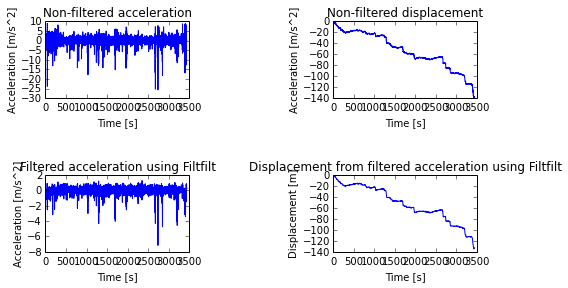

In [27]:
#Purisa Jasmine Simmons
#July 12, 2018
#Algorithm to filter acceleration data using FiltFilt, before calculating displacements.

%matplotlib inline

from scipy import signal

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from plotly import tools
import plotly.offline
import plotly.graph_objs as go

import math
import re

#Need to do peak-picking before algorithm runs:
#1. Read through file, save all times and accelerations:
print('Running WaveStats Algorithm:')

#Reading data from filename_r
filename_r = "Motion_13735.CSV"
read_file = open(filename_r, "r")

#Initialize lists
t1 = 0 
t2 = 0
time_e_list = []  #list of ***elapsed*** times
time_o_list = []  #list of ***offset*** times
acc_list = []     #list of estimated accelerations
disp_list = []    #list of estimated displacements
disp_list_f = []    #list of estimated displacements


print 'Extracting data from file...'
with open(filename_r, 'r') as f: 
  for line in f:
    str_array = line.split(',')  #separates each line into an array on commas

    #-------Calculating Time Offset--------#
    if str_array[0] == "UTC":
      t1 = 0
      t2 = 0
      time_e_list.append(0)
      time_o_list.append(0)

    else:
      t2 = str_array[0]

      if (t2 != 0 and t1 != 0 and str_array[2] != "N/A"):
        time_regex = r"(\.\d+)"
        t2_val = float(re.search(time_regex, t2).group(1))
        t1_val = float(re.search(time_regex, t1).group(1))

        #print t2_val
        #print t1_val

        t_out = t2_val - t1_val #measured in secs

        #t_out is the time offset between two subsequent samples
        if (t_out < 0): 
          t_out = t_out + 1

        #print ("Printing time_offsets")
     
        last = len(time_e_list) - 1
        last_time = time_e_list[last] 
        new_time = t_out + last_time  #new_time is the total elapsed time

        time_e_list.append(new_time)
        time_o_list.append(t_out)

      if (str_array[2] != "N/A" and str_array[3] != "N/A" and \
        str_array[4] != "N/A" and str_array[2] != "IMU A1"):

        g_const = 512     #g_const is scaling constant: 500 (500raw units = 1g)
        gravity = -9.80665 #gravity is the constant 9.80665m^2/s 

        ax = int(str_array[2])  #x-axis (horizontal direction 1)
        #ax = (ax/g_const)*gravity
        ay = int(str_array[3])  #y-axis, affected by gravity (vertical)
        #ay = (ay/g_const)*gravity
        az = int(str_array[4])  #z-axis (horizontal direction 2)
        #az = (az/g_const)*gravity


        #Calculate the magnitude of acceleration from all three axes:
        a_mag = math.sqrt(ax**2 + ay**2 + az**2)

        #Double integrate aA to get approximate distance b/w wave trough and crest
        #aA = a_mag - gravity     #aA is the approximated vertical acceleration
        aA = (a_mag/g_const)*gravity - gravity

    
        #print aA

        acc_list.append(aA)


    #Reset t1 and t2 after t_out is calculated
    t1 = t2
    t2 = 0

#----------Here, after both lists created, now filter acceleration data----------
time_array = np.array(time_e_list)
acc_array = np.array(acc_list)


#-------Generating non-filtered displacement data here:
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_list)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_list[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list) - 1      #index of last element in disp_list
    last_d = disp_list[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#-------Now filtering acceleration data:

#b is the numerator coefficient vector of the filter
#a is the denominator coefficient vector of the filter
b, a = signal.butter(8, 0.125)
x = acc_array
y = signal.filtfilt(b, a, x, padlen=150)

acc_fil = y
#-------------------Here, after filtering---------------
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_fil)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list_f.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_fil[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list_f) - 1      #index of last element in disp_list
    last_d = disp_list_f[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list_f.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list_f)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#--------Here, after calculations, ready to graph---------

disp_array = np.array(disp_list)
disp_array_f = np.array(disp_list_f)
acc_fil_array = np.array(acc_fil)

plt.subplot(2, 2, 1)
plt.plot(time_array, acc_array)
plt.title('Non-filtered acceleration')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 2)
plt.plot(time_array, disp_array)
plt.title('Non-filtered displacement')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 3)
plt.plot(time_array, acc_fil_array)
plt.title('Filtered acceleration using Filtfilt')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')
         
plt.subplot(2, 2, 4)
plt.plot(time_array, disp_array_f)
plt.title('Displacement from filtered acceleration using Filtfilt')
plt.ylabel('Displacement [m]')
plt.xlabel('Time [s]')


#plt.tight_layout()

plt.subplots_adjust(left=0.001, bottom=0.1, right=1.0, top=0.9,
                wspace=1.0, hspace=1.0)

plt.show()

In [ ]:
#Now, using just y-axis for vertical displacement since we know this one is in the water.
#Some changes: Instead of using UTC time, using "Time" column for more accuracy:
#This is in milliseconds, so we need to multiply by 10^-3.

Running WaveStats Algorithm:
Extracting data from file...
251.0
250.0
251.0
249.0
250.0
251.0
251.0
250.0
252.0
250.0
252.0
250.0
243.0
251.0
251.0
251.0
251.0
255.0
250.0
250.0
241.0
253.0
250.0
251.0
251.0
251.0
250.0
251.0
251.0
251.0
242.0
250.0
250.0
250.0
250.0
251.0
251.0
251.0
250.0
251.0
251.0
244.0
250.0
251.0
250.0
253.0
251.0
252.0
250.0
252.0
250.0
242.0
252.0
250.0
250.0
201.0
200.0
201.0
201.0
200.0
201.0
200.0
200.0
200.0
250.0
252.0
250.0
243.0
251.0
250.0
250.0
252.0
250.0
252.0
250.0
251.0
251.0
241.0
250.0
251.0
250.0
250.0
252.0
250.0
250.0
251.0
250.0
251.0
250.0
250.0
250.0
247.0
251.0
250.0
252.0
250.0
250.0
252.0
250.0
250.0
250.0
250.0
252.0
250.0
242.0
250.0
251.0
251.0
251.0
252.0
249.0
250.0
250.0
250.0
252.0
244.0
251.0
251.0
251.0
251.0
251.0
251.0
251.0
251.0
250.0
250.0
250.0
241.0
250.0
251.0
251.0
251.0
250.0
251.0
251.0
250.0
250.0
252.0
250.0
244.0
251.0
252.0
250.0
250.0
251.0
250.0
250.0
251.0
251.0
250.0
250.0
250.0
253.0
249.0
242.0
250.0
252.0


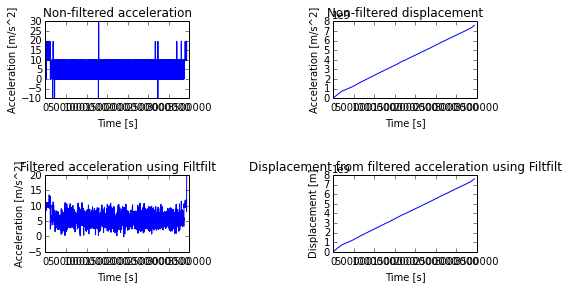

In [35]:
#Purisa Jasmine Simmons
#July 12, 2018
#Algorithm to filter acceleration data using FiltFilt, before calculating displacements.

%matplotlib inline

from scipy import signal

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from plotly import tools
import plotly.offline
import plotly.graph_objs as go

import math
import re

#Need to do peak-picking before algorithm runs:
#1. Read through file, save all times and accelerations:
print('Running WaveStats Algorithm:')

#Reading data from filename_r
filename_r = "Motion_13735.CSV"
read_file = open(filename_r, "r")

#Initialize lists
t1 = 0 
t2 = 0
time_e_list = []  #list of ***elapsed*** times
time_o_list = []  #list of ***offset*** times
acc_list = []     #list of estimated accelerations
disp_list = []    #list of estimated displacements
disp_list_f = []    #list of estimated displacements


print 'Extracting data from file...'
with open(filename_r, 'r') as f: 
  for line in f:
    str_array = line.split(',')  #separates each line into an array on commas

    #-------Calculating Time Offset--------#
    if str_array[0] == "UTC":
      t1 = 0
      t2 = 0
      time_e_list.append(0)
      time_o_list.append(0)

    else:
      t2 = str_array[1]

      if (t2 != 0 and t1 != 0 and str_array[2] != "N/A"):
        #time_regex = r"(\.\d+)"
        #t2_val = float(re.search(time_regex, t2).group(1))
        #t1_val = float(re.search(time_regex, t1).group(1))

        #print t2_val
        #print t1_val

        t_out = float(t2) - float(t1) #measured in seconds
    
        print(t_out)

        #print ("Printing time_offsets")
     
        last = len(time_e_list) - 1
        last_time = time_e_list[last] 
        new_time = t_out + last_time  #new_time is the total elapsed time

        time_e_list.append(new_time)
        time_o_list.append(t_out)

      if (str_array[2] != "N/A" and str_array[3] != "N/A" and \
        str_array[4] != "N/A" and str_array[2] != "IMU A1"):

        g_const = 512     #g_const is scaling constant: 500 (500raw units = 1g)
        gravity = -9.80665 #gravity is the constant 9.80665m^2/s 

        
        ay = int(str_array[3])  #y-axis, affected by gravity (vertical)
        ay = (ay/g_const)*gravity - gravity
        

        #Calculate the magnitude of acceleration from all three axes:
        #a_mag = math.sqrt(ax**2 + ay**2 + az**2)

        #Double integrate aA to get approximate distance b/w wave trough and crest
        #aA = a_mag - gravity     #aA is the approximated vertical acceleration
        #aA = (a_mag/g_const)*gravity - gravity

    
        #print aA

        acc_list.append(ay)


    #Reset t1 and t2 after t_out is calculated
    t1 = t2
    t2 = 0

#----------Here, after both lists created, now filter acceleration data----------
time_array = np.array(time_e_list)
acc_array = np.array(acc_list)


#-------Generating non-filtered displacement data here:
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_list)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_list[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list) - 1      #index of last element in disp_list
    last_d = disp_list[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#-------Now filtering acceleration data:

#b is the numerator coefficient vector of the filter
#a is the denominator coefficient vector of the filter
b, a = signal.butter(8, 0.125)
x = acc_array
y = signal.filtfilt(b, a, x, padlen=150)

acc_fil = y
#-------------------Here, after filtering---------------
len1 = len(time_e_list)
len2 = len(time_o_list)
len3 = len(acc_fil)

if (len1 != len2 or len1 != len3):
  print("Error: Lengths of lists do not match!")
  print(len1)
  print(len2)
  print(len3)

else:
  #Initializations
  a0 = 0
  v0 = 0
  d0 = 0
  i = 0

  disp_list_f.append(0)

  #Calculations
  while (i < len1 - 1):
    t = time_o_list[i]
    a_new = acc_fil[i]
    v_new = a_new*t + v0
    d_new = (0.5*a_new*(t**2)) + v_new*t + d0

    #print(d_new)

    last_di = len(disp_list_f) - 1      #index of last element in disp_list
    last_d = disp_list_f[last_di]       #last elem from disp_list
    total_d = d_new + last_d
    disp_list_f.append(total_d)

    #print(total_d)

    i = i + 1


len4 = len(disp_list_f)
if (len1 != len4):
  print("Error: Lengths of disp_list doesn't match!")
  print("Length of disp_list is: %d while len of acc_list is: %d")%(len(disp_list), len(acc_list))

#--------Here, after calculations, ready to graph---------

disp_array = np.array(disp_list)
disp_array_f = np.array(disp_list_f)
acc_fil_array = np.array(acc_fil)

plt.subplot(2, 2, 1)
plt.plot(time_array, acc_array)
plt.title('Non-filtered acceleration')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 2)
plt.plot(time_array, disp_array)
plt.title('Non-filtered displacement')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')

plt.subplot(2, 2, 3)
plt.plot(time_array, acc_fil_array)
plt.title('Filtered acceleration using Filtfilt')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')
         
plt.subplot(2, 2, 4)
plt.plot(time_array, disp_array_f)
plt.title('Displacement from filtered acceleration using Filtfilt')
plt.ylabel('Displacement [m]')
plt.xlabel('Time [s]')


#plt.tight_layout()

plt.subplots_adjust(left=0.001, bottom=0.1, right=1.0, top=0.9,
                wspace=1.0, hspace=1.0)

plt.show()